In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Data Prep

The current data lies in this format.

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
df = pd.read_json("assg2/predictions_and_labels.json")
df.head()

,Y,Y_pred
0,[],"[0.663909575266531, 0.26850002057452504, 0.139..."
1,"[1, 2, 3]","[0.754548219990892, 0.610512270727502, 0.59466..."
2,[3],"[0.361971855895842, 0.06889878302158, 0.390805..."
3,"[2, 3]","[0.272751101487395, 0.7266499116805311, 0.7930..."
4,[2],"[0.7058318281532171, 0.751104944156462, 0.4008..."


In [4]:
def pad_values(inpt):
    res = []
    for x in [1,2,3]:
        if x in inpt : 
            res+= [1]
        else:
            res+=[0]
    return res

df["res_array"] = df["Y"].apply(lambda x : pad_values(x))

In [5]:
df['1'] = df['res_array'].apply(lambda x : x[0])
df['2'] = df['res_array'].apply(lambda x : x[1])
df['3'] = df['res_array'].apply(lambda x : x[2])
df["n_groundtruth"] = df[['1', '2', '3']].apply(sum,axis=1)
#
df['1_preds'] = df['Y_pred'].apply(lambda x : x[0])
df['2_preds'] = df['Y_pred'].apply(lambda x : x[2])
df['3_preds'] = df['Y_pred'].apply(lambda x : x[2])


We will do the following transformations:

1.From ground truth- **Y**- extract all classes and one hot encode them. '1' would mean that the label was detected while '0' means the opposite.

2.In **Y_preds** the field contains of 3 values that hold the probability for each class. This would be extracted in other columns.
    
The resultant columns are 
1. Y -> 1, 2, 3
2. Y_pred -> 1-preds, 2_preds, 3_preds

In [6]:
df.head()

,Y,Y_pred,res_array,1,2,3,n_groundtruth,1_preds,2_preds,3_preds
0,[],"[0.663909575266531, 0.26850002057452504, 0.139...","[0, 0, 0]",0,0,0,0,0.663910,0.139674,0.139674
1,"[1, 2, 3]","[0.754548219990892, 0.610512270727502, 0.59466...","[1, 1, 1]",1,1,1,3,0.754548,0.594662,0.594662
2,[3],"[0.361971855895842, 0.06889878302158, 0.390805...","[0, 0, 1]",0,0,1,1,0.361972,0.390805,0.390805
3,"[2, 3]","[0.272751101487395, 0.7266499116805311, 0.7930...","[0, 1, 1]",0,1,1,2,0.272751,0.793074,0.793074
4,[2],"[0.7058318281532171, 0.751104944156462, 0.4008...","[0, 1, 0]",0,1,0,1,0.705832,0.400873,0.400873


By looking at the data we can understand that the three are independent events since their probabilities dont add up to 1. Lets visualize the Y_pred variable which is the sum of probabilities.

In [7]:
df['Y_pred'].apply(sum).describe()

count    10000.000000
mean         1.501273
std          0.463676
min          0.162275
25%          1.166824
50%          1.501346
75%          1.835592
max          2.778599
Name: Y_pred, dtype: float64

We can  observe that the probabilities don't add up to 1. Hence each of these events are independent events. As a result each label can be intrepreted as a binary classification problem.

In [8]:
df[['1_preds', '2_preds', '3_preds']].describe()

,1_preds,2_preds,3_preds
count,10000.000000,10000.000000,10000.000000
mean,0.498206,0.501867,0.501867
std,0.269919,0.267828,0.267828
min,0.009423,0.010636,0.010636
25%,0.253087,0.266574,0.266574
50%,0.498270,0.502515,0.502515
75%,0.741668,0.741692,0.741692
max,0.995844,0.991232,0.991232


## Q1 : Can you explain the precision-recall tradeoff?

> **Precision and Recall: A Tug of War**

> To fully evaluate the effectiveness of a model, you must examine both precision and recall. Unfortunately, precision and recall are often in tension. That is, improving precision typically reduces recall and vice versa.


We can see this in action. Lets plot the precision VS recall curve for all three labels. 

The threshold range is from 0.1 to 0.95 with a step of 0.1

In [9]:
res = []
for label in ['1', '2', '3'] : 
    #
    orignal = list(df[label])
    preds = list(df['{}_preds'.format(label)])
    #
    for th in np.arange(0.1, 0.95, 0.01) : 
        #
        true_labels = np.asarray(orignal)
        pred_labels = np.asarray(list(map(lambda x : 1 if x > th else 0, preds)))
        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

        #res
        fp_rate = (FP) *100 / (FP+TN)
        tp_rate = (TP) *100 / (TP+FN) # recall
        precision = (TP) *100 / (TP + FP) #precision
        res += [(label, th, TP, TN, FP, FN, fp_rate,tp_rate, precision)]
df2 = pd.DataFrame(res, columns = ['label','threshold','TP', 'TN', 'FP', 'FN' ,'FP_RATE','TP_RATE', 'precision'])
   

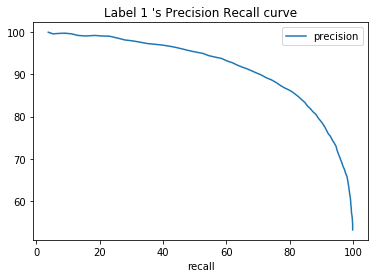

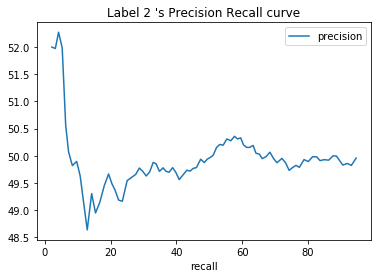

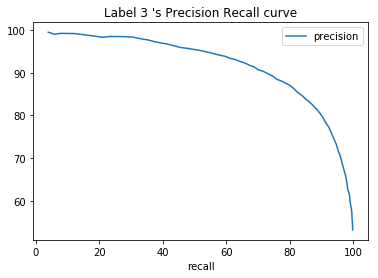

In [10]:
# Precision recall curve
for label in ['1', '2', '3'] : 
    fig, ax = plt.subplots()
    #
    df2[df2['label'] == label].rename(columns = {"TP_RATE" : "recall"}).plot(ax=ax, x='recall', y='precision')
    ax.set_title("Label {} 's Precision Recall curve".format(label))

Something strange is going on with label 2. We might explore that as we move along.

# Q2 : What prediction threshold should we set to have the best true positive rate ( ie. recall) at a maximum false positive rate of 20%?

The approach would be:
1. Iterate over a longer range of threshold values for each label while calculating the relevant metrics - TruePositives, True Negatives, etc. For example we will iterate over the threshold range of 0.1 to 0.95 using a step of 0.01. At each threshold value the metrics would be calculated.
2. After identifying top candidates for threshold for each individual threshold - explore a more finer grain, ie, narrow down the threshold range but at a finer grain. For example if label 1 has top candidates for a threshold of 0.15 and 0.20 we will iterate over 0.12 to 0.24(expanding the range by a tiny margin ) where each step would be 0.001. This is essentially STEP 1 but narrowed down. 
3. Repeat- identify the top candidates using parameters specified in the question.

## Results at a Glance [for convinience]

For label 1, the best threshold is 0.4616 respect to a false Positive rate of 19.99% and best true positive rate of 87.27%

For label 2, the best threshold is 0.7860 with respect to a false Positive rate of 19.99% and best true positive rate of 19.76%

For label 3, the best threshold is 0.45507 with respect to a false Positive rate of 19.99% and best true positive rate of 88.2%

**The approach is implemented in the below cells.**


## For label 1- fine tune the exact rate by experimentation

In [11]:
df2[(df2['FP_RATE'] <=20) & (df2['label']=='1')].sort_values(by = 'TP_RATE', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
37,1,0.47,4311,4063,950,676,18.950728,86.444756,81.942596
38,1,0.48,4267,4112,901,720,17.973269,85.562462,82.565789
39,1,0.49,4229,4168,845,758,16.856174,84.800481,83.346472
40,1,0.50,4183,4214,799,804,15.938560,83.878083,83.962264
41,1,0.51,4130,4267,746,857,14.881309,82.815320,84.700574


In [12]:
res = []
for label in ['1'] : 
    #
    orignal = list(df[label])
    preds = list(df['{}_preds'.format(label)])
    #
    for th in np.arange(0.44, 0.53, 0.0001) : 
        #
        true_labels = np.asarray(orignal)
        pred_labels = np.asarray(list(map(lambda x : 1 if x > th else 0, preds)))
        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

        #res
        fp_rate = (FP) *100 / (FP+TN)
        tp_rate = (TP) *100 / (TP+FN) # recall
        precision = (TP) *100 / (TP + FP) #precision
        res += [(label, th, TP, TN, FP, FN, fp_rate,tp_rate, precision)]
df3 = pd.DataFrame(res, columns = ['label','threshold','TP', 'TN', 'FP', 'FN' ,'FP_RATE','TP_RATE', 'precision'])
   

In [13]:
df3[(df3['FP_RATE'] <=20) & (df3['label']=='1')].sort_values(by = 'TP_RATE', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
215,1,0.4615,4352,4011,1002,635,19.988031,87.266894,81.285021
216,1,0.4616,4352,4012,1001,635,19.968083,87.266894,81.300205
217,1,0.4617,4351,4014,999,636,19.928187,87.246842,81.327103
221,1,0.4621,4351,4017,996,636,19.868342,87.246842,81.372732
223,1,0.4623,4351,4019,994,636,19.828446,87.246842,81.403181


For label 1, the best threshold is 0.4616 respect to a false Positive rate of 19.99% and best true positive rate of 87.27%

## For label 2- fine tune the exact rate by experimentation

In [14]:
df2[(df2['FP_RATE'] <=20) & (df2['label']=='2')].sort_values(by = 'TP_RATE', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
154,2,0.79,966,4028,979,4027,19.552626,19.347086,49.665810
155,2,0.80,901,4086,921,4092,18.394248,18.045263,49.451153
156,2,0.81,833,4145,862,4160,17.215898,16.683357,49.144543
157,2,0.82,768,4206,801,4225,15.997603,15.381534,48.948375
158,2,0.83,709,4278,729,4284,14.559617,14.199880,49.304590


In [15]:
res = []
for label in ['2'] : 
    #
    orignal = list(df[label])
    preds = list(df['{}_preds'.format(label)])
    #
    for th in np.arange(0.75, 0.83, 0.0001) : 
        #
        true_labels = np.asarray(orignal)
        pred_labels = np.asarray(list(map(lambda x : 1 if x > th else 0, preds)))
        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

        #res
        fp_rate = (FP) *100 / (FP+TN)
        tp_rate = (TP) *100 / (TP+FN) # recall
        precision = (TP) *100 / (TP + FP) #precision
        res += [(label, th, TP, TN, FP, FN, fp_rate,tp_rate, precision)]
df3 = pd.DataFrame(res, columns = ['label','threshold','TP', 'TN', 'FP', 'FN' ,'FP_RATE','TP_RATE', 'precision'])
   

In [16]:
df3[(df3['FP_RATE'] <=20) & (df3['label']=='2')].sort_values(by = 'TP_RATE', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
360,2,0.7860,987,4006,1001,4006,19.992011,19.767675,49.647887
361,2,0.7861,986,4006,1001,4007,19.992011,19.747647,49.622547
362,2,0.7862,984,4007,1000,4009,19.972039,19.707591,49.596774
363,2,0.7863,984,4007,1000,4009,19.972039,19.707591,49.596774
364,2,0.7864,983,4007,1000,4010,19.972039,19.687563,49.571357


For label 2, the best threshold is 0.7860 with respect to a false Positive rate of 19.99% and best true positive rate of 19.76%

## For label 3- fine tune the exact rate by experimentation

In [17]:
df2[(df2['FP_RATE'] <=20) & (df2['label']=='3')].sort_values(by = 'TP_RATE', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
206,3,0.46,4422,3994,969,615,19.524481,87.790351,82.025598
207,3,0.47,4375,4050,913,662,18.396131,86.857256,82.734493
208,3,0.48,4329,4096,867,708,17.469273,85.944014,83.314088
209,3,0.49,4283,4139,824,754,16.602861,85.030772,83.865283
210,3,0.50,4244,4182,781,793,15.736450,84.256502,84.457711


In [18]:
res = []
for label in ['3'] : 
    #
    orignal = list(df[label])
    preds = list(df['{}_preds'.format(label)])
    #
    for th in np.arange(0.44, 0.47, 0.00001) : 
        #
        true_labels = np.asarray(orignal)
        pred_labels = np.asarray(list(map(lambda x : 1 if x > th else 0, preds)))
        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

        #res
        fp_rate = (FP) *100 / (FP+TN)
        tp_rate = (TP) *100 / (TP+FN) # recall
        precision = (TP) *100 / (TP + FP) #precision
        res += [(label, th, TP, TN, FP, FN, fp_rate,tp_rate, precision)]
df3 = pd.DataFrame(res, columns = ['label','threshold','TP', 'TN', 'FP', 'FN' ,'FP_RATE','TP_RATE', 'precision'])
   

In [19]:
df3[(df3['FP_RATE'] <=20) & (df3['label']=='3')].sort_values(by = 'TP_RATE', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
1507,3,0.45507,4443,3971,992,594,19.987911,88.207266,81.747930
1523,3,0.45523,4443,3973,990,594,19.947612,88.207266,81.778023
1537,3,0.45537,4443,3976,987,594,19.887165,88.207266,81.823204
1536,3,0.45536,4443,3975,988,594,19.907314,88.207266,81.808138
1535,3,0.45535,4443,3975,988,594,19.907314,88.207266,81.808138


For label 3, the best threshold is 0.45507 with respect to a false Positive rate of 19.99% and best true positive rate of 88.2%

# Q3: What prediction threshold should we set to have the best precision at a minimum recall of 80%?

The approach for this question is similar to that of Q2 albeit different constraints.

## Results at a Glance [for convinience]

For label 1, the best threshold is 0.5355 with respect to a recall of 80.1% and best precision of 86.15%

For label 2, the best threshold is 0.15152 with respect to a recall of 88.52% and best precision of 50%

For label 3, the best threshold is 0.53897 with respect to a recall of 80% and best precision of 87%

**The approach is implemented in the below cells.**


## For label 1- fine tune the exact rate by experimentation

In [20]:
df2[(df2['TP_RATE'] >=80) & (df2['label']=='1')].sort_values(by = 'precision', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
43,1,0.53,4028,4351,662,959,13.205665,80.770002,85.884861
42,1,0.52,4080,4309,704,907,14.043487,81.812713,85.284281
41,1,0.51,4130,4267,746,857,14.881309,82.815320,84.700574
40,1,0.50,4183,4214,799,804,15.938560,83.878083,83.962264
39,1,0.49,4229,4168,845,758,16.856174,84.800481,83.346472


In [21]:
res = []
for label in ['1'] : 
    #
    orignal = list(df[label])
    preds = list(df['{}_preds'.format(label)])
    #
    for th in np.arange(0.50, 0.55, 0.0001) : 
        #
        true_labels = np.asarray(orignal)
        pred_labels = np.asarray(list(map(lambda x : 1 if x > th else 0, preds)))
        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

        #res
        fp_rate = (FP) *100 / (FP+TN)
        tp_rate = (TP) *100 / (TP+FN) # recall
        precision = (TP) *100 / (TP + FP) #precision
        res += [(label, th, TP, TN, FP, FN, fp_rate,tp_rate, precision)]
df3 = pd.DataFrame(res, columns = ['label','threshold','TP', 'TN', 'FP', 'FN' ,'FP_RATE','TP_RATE', 'precision'])
   

In [22]:
df3[(df3['TP_RATE'] >=80)].sort_values(by = 'precision', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
355,1,0.5355,3995,4371,642,992,12.806703,80.108282,86.154841
356,1,0.5356,3994,4371,642,993,12.806703,80.088229,86.151855
357,1,0.5357,3993,4371,642,994,12.806703,80.068177,86.148867
359,1,0.5359,3992,4371,642,995,12.806703,80.048125,86.145878
358,1,0.5358,3992,4371,642,995,12.806703,80.048125,86.145878


For label 1, the best threshold is 0.5355 with respect to a recall of 80.1% and best precision of 86.15%

## For label 2- fine tune the exact rate by experimentation

In [23]:
df2[(df2['TP_RATE'] >=80) & (df2['label']=='2')].sort_values(by = 'precision', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
91,2,0.16,4375,632,4375,618,87.377671,87.622672,50.000000
90,2,0.15,4427,579,4428,566,88.436189,88.664130,49.994353
95,2,0.20,4124,880,4127,869,82.424606,82.595634,49.981820
96,2,0.21,4063,941,4066,930,81.206311,81.373923,49.981548
85,2,0.10,4725,274,4733,268,94.527661,94.632485,49.957708


In [24]:
res = []
for label in ['2'] : 
    #
    orignal = list(df[label])
    preds = list(df['{}_preds'.format(label)])
    #
    for th in np.arange(0.11, 0.24, 0.00001) : 
        #
        true_labels = np.asarray(orignal)
        pred_labels = np.asarray(list(map(lambda x : 1 if x > th else 0, preds)))
        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

        #res
        fp_rate = (FP) *100 / (FP+TN)
        tp_rate = (TP) *100 / (TP+FN) # recall
        precision = (TP) *100 / (TP + FP) #precision
        res += [(label, th, TP, TN, FP, FN, fp_rate,tp_rate, precision)]
df3 = pd.DataFrame(res, columns = ['label','threshold','TP', 'TN', 'FP', 'FN' ,'FP_RATE','TP_RATE', 'precision'])
   

In [25]:
df3[(df3['TP_RATE'] >=80)].sort_values(by = 'precision', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
4152,2,0.15152,4420,593,4414,573,88.156581,88.523934,50.033960
4153,2,0.15153,4420,593,4414,573,88.156581,88.523934,50.033960
4154,2,0.15154,4420,593,4414,573,88.156581,88.523934,50.033960
4136,2,0.15136,4421,592,4415,572,88.176553,88.543962,50.033952
4135,2,0.15135,4421,592,4415,572,88.176553,88.543962,50.033952


For label 2, the best threshold is 0.15152 with respect to a recall of 88.52% and best precision of 50%

## For label 3- fine tune the exact rate by experimentation

In [26]:
df2[(df2['TP_RATE'] >=80) & (df2['label']=='3')].sort_values(by = 'precision', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
213,3,0.53,4090,4319,644,947,12.976023,81.199126,86.396282
212,3,0.52,4148,4261,702,889,14.144671,82.350606,85.525773
211,3,0.51,4197,4222,741,840,14.930486,83.323407,84.993925
210,3,0.50,4244,4182,781,793,15.736450,84.256502,84.457711
209,3,0.49,4283,4139,824,754,16.602861,85.030772,83.865283


In [27]:
res = []
for label in ['3'] : 
    #
    orignal = list(df[label])
    preds = list(df['{}_preds'.format(label)])
    #
    for th in np.arange(0.45, 0.56, 0.00001) : 
        #
        true_labels = np.asarray(orignal)
        pred_labels = np.asarray(list(map(lambda x : 1 if x > th else 0, preds)))
        # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
        TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))

        #res
        fp_rate = (FP) *100 / (FP+TN)
        tp_rate = (TP) *100 / (TP+FN) # recall
        precision = (TP) *100 / (TP + FP) #precision
        res += [(label, th, TP, TN, FP, FN, fp_rate,tp_rate, precision)]
df3 = pd.DataFrame(res, columns = ['label','threshold','TP', 'TN', 'FP', 'FN' ,'FP_RATE','TP_RATE', 'precision'])
   

In [28]:
df3[(df3['TP_RATE'] >=80)].sort_values(by = 'precision', ascending = False).head()

,label,threshold,TP,TN,FP,FN,FP_RATE,TP_RATE,precision
8897,3,0.53897,4032,4364,599,1005,12.069313,80.047647,87.065429
8901,3,0.53901,4032,4364,599,1005,12.069313,80.047647,87.065429
8896,3,0.53896,4032,4364,599,1005,12.069313,80.047647,87.065429
8898,3,0.53898,4032,4364,599,1005,12.069313,80.047647,87.065429
8899,3,0.53899,4032,4364,599,1005,12.069313,80.047647,87.065429


For label 3, the best threshold is 0.53897 with respect to a recall of 80% and best precision of 87%